<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Clustering</center></h2>

# About

The goal of this seminar is to consider clustering approaches and demonstrate algorithms implemented in [scikit-learn](https://scikit-learn.org) library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Part 1: Clustering

## Data Preparation

In [2]:
from sklearn import datasets

n_samples = 1500
random_state = 170
X, y = datasets.make_blobs(centers=3, n_samples=n_samples, random_state=random_state, center_box=(-10, 10))

# To play with
# X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
# X, y = datasets.make_moons(n_samples=n_samples, noise=.05)
# X = np.random.rand(n_samples, 2)

In [3]:
X[:5]

array([[ -5.19811282,   0.64186932],
       [ -5.75229538,   0.41862711],
       [-10.84489837,  -7.55352273],
       [ -4.57098483,  -0.80101741],
       [ -3.51916215,   0.0393449 ]])

In [4]:
y[:5]

array([1, 1, 0, 1, 1])

In [5]:
def plot_clusters(X, y):

    # Create an figure with a custom size
    # plt.figure(figsize=(6, 4))
    
    if y is not None:
        for cluster_label in np.unique(y):
            # Plot all objects with y == i (class 0)
            plt.scatter(X[y == cluster_label, 0],     # selects all objects with y == i and the 1st column of X
                        X[y == cluster_label, 1],     # selects all objects with y == i and the 2nd column of X
                        label=str(cluster_label))     # label for the plot legend
    else:
        plt.scatter(X[:, 0], X[:, 1], label='samples')

    plt.xlabel('X1', size=12) # set up X-axis label
    plt.ylabel('X2', size=12) # set up Y-axis label
    plt.xticks(size=12)
    plt.yticks(size=12)

    plt.legend(loc='best', fontsize=12) # create the plot legend and set up it position
    plt.grid(b=1) # create grid on the plot

    plt.show() # display the plot

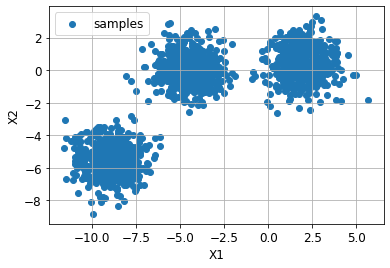

In [6]:
plot_clusters(X, y=None)

## Clustering: K-Means

Suppose we have $N$ samples and $K$ clusters. Each cluster is described by its center (centroid) with coordinates $\mu_{j}$. The centroids are estimated by minimizing **within-cluster distance criterion**:

$$
L = \sum_{i=1}^{N} \min_{\mu_{k}} \rho(x_{i}, \mu_{k}) \to \min_{\mu_{1}, ..., \mu_{K}}
$$

$$
\rho(x_{i}, \mu_{k}) = || x_{i} - \mu_{k} ||^{2}
$$

where $x_{i}$ is a sample coordinates, $\rho(x_{i}, \mu_{k})$ is distance between the $i$-th sample and the $k$-th cluster's centroid.

**K-Means algorithm:**

<center><img src="img/kmeans-alg.png" width=400></center>

<center><img src="img/kmean1.png" width=500></center>

In [7]:
from sklearn.utils import resample


class MyKmeans(object):
    
    
    def __init__(self, n_clusters=2, max_iter=10, n_init=10):
        """
        K-Means clustering algorithms implementation.
        
        Parameters:
        -----------
        n_clusters: int
            Number of clusters.
        max_iters: int
            Number of iterations of the centroids search.
        n_init: int
            Number of different initializations of the centroids.
        """
        
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init
        
        
    
    def _predict_for_centers(self, cluster_centers, X):
        """
        Predict cluster labels based on their centroids.
        
        Parameters:
        -----------
        cluster_centers: numpy.array
            Array of the cluster centers.
        X: numpy.array
            Samples coordinates.
        
        Returns:
        --------
        labels: numpy.array
            Predicted cluster labels. Example: labels = [0, 0, 1, 1, 0, 2, ...].
        """
        
        object_distances2 = []
        for one_cluster_center in cluster_centers:
            dist2 = ((X - one_cluster_center)**2).sum(axis=1)
            object_distances2.append(dist2)
        object_distances2 = np.array(object_distances2)
        labels = np.argmin(object_distances2, axis=0)
        
        return labels
    
    
    
    def _calculate_cluster_centers(self, X, y):
        """
        Estimate cluster centers based on samples in these clusters.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        y: numpy.array
            Cluster labels of the samples.
        
        Returns:
        --------
        cluster_centers: numpy.array
            Estimated cluster centers.
        """
        
        cluster_centers = []
        cluster_labels = np.unique(y)
        
        for one_cluster_label in cluster_labels:
            one_cluster_center = X[y == one_cluster_label].mean(axis=0)
            cluster_centers.append(one_cluster_center)
            
        return np.array(cluster_centers)
    
    
    
    def _calculate_cluster_metric(self, cluster_centers, X):
        """
        Calculate within-cluster distance criterion.
        
        Parameters:
        -----------
        cluster_centers: numpy.array
            Array of the cluster centers.
        X: numpy.array
            Samples coordinates.
        
        Returns:
        --------
        criterion: float
            The criterion value.
        """
        
        object_distances2 = []
        for one_cluster_center in cluster_centers:
            dist2 = ((X - one_cluster_center)**2).sum(axis=1)
            object_distances2.append(dist2)
        object_distances2 = np.array(object_distances2)
        min_dists2 = np.min(object_distances2, axis=0)
        criterion = min_dists2.mean()
        
        return criterion
    
    
    
    def _fit_one_init(self, X):
        """
        Run k-Means algorithm for randomly init cluster centers.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        
        Returns:
        --------
        cluster_centers: numpy.array
            Estimated cluster centers.
        metric: float
            Within-cluster distance criterion criterion value.
        """
        
        # Init cluster centers
        cluster_centers = resample(X, n_samples=self.n_clusters, random_state=None, replace=False)
        
        # Search for cluster centers
        for i in range(self.max_iter):
            labels = self._predict_for_centers(cluster_centers, X)
            cluster_centers = self._calculate_cluster_centers(X, labels)
            
        # Calculate within-cluster distance criterion
        metric = self._calculate_cluster_metric(cluster_centers, X)
            
        return cluster_centers, metric
    
        
        
    def fit(self, X):
        """
        Run k-Means algorithm.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        """
        
        self.best_cluster_centers = None
        self.best_metric = np.inf
        
        for i in range(self.n_init):
            
            # Run K-Means algorithms for randomly init cluster centers
            cluster_centers, metric = self._fit_one_init(X)
            
            # Save the best clusters
            if metric < self.best_metric:
                self.best_metric = metric
                self.best_cluster_centers = cluster_centers
                
    
    def predict(self, X):
        """
        Predict cluster labels.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        
        Returns:
        --------
        y: numpy.array
            Predicted cluster labels. Example: labels = [0, 0, 1, 1, 0, 2, ...].
        """
        
        y = self._predict_for_centers(self.best_cluster_centers, X)
        
        return y

In [8]:
clusterer = MyKmeans(n_clusters=3, max_iter=20, n_init=10)
clusterer.fit(X)
y_pred = clusterer.predict(X)

In [9]:
y_pred[:10]

array([0, 0, 1, 0, 0, 2, 1, 1, 1, 2])

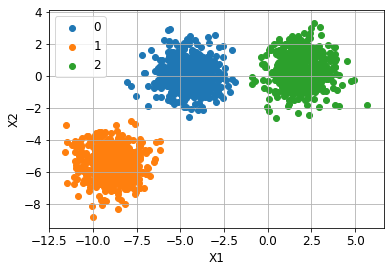

In [10]:
plot_clusters(X, y_pred)

## Metrics

**Silhouette Score:**

$$
s = \frac{b - a}{max(a, b)}
$$

- **a**: The mean distance between a sample and all other points in the same class.
- **b**: The mean distance between a sample and all other points in the next nearest cluster.


**Adjusted Rand Index (ARI):**

$$
ARI = \frac{RI - Expected\_RI}{max(RI) - Expected\_RI}
$$

$$
RI = \frac{a + b}{a + b + c + d}
$$


- a, the number of pairs of elements in S that are in the same subset in X and in the same subset in Y
- b, the number of pairs of elements in S that are in different subsets in X and in different subsets in Y
- c, the number of pairs of elements in S that are in the same subset in X and in different subsets in Y
- d, the number of pairs of elements in S that are in different subsets in X and in the same subset in Y

In [11]:
from sklearn import metrics

silhouette_score_values = []
adjusted_rand_score_values = []
within_cluster_dist_values = []
n_clusters = np.arange(2, 21)

for n in n_clusters:
    
    clusterer = MyKmeans(n_clusters=n, max_iter=10, n_init=10)
    clusterer.fit(X)
    y_pred = clusterer.predict(X)
    
    score1 = metrics.silhouette_score(X, y_pred)
    silhouette_score_values.append(score1)
    
    score2 = metrics.adjusted_rand_score(y, y_pred)
    adjusted_rand_score_values.append(score2)
    
    score3 = clusterer.best_metric
    within_cluster_dist_values.append(score3)

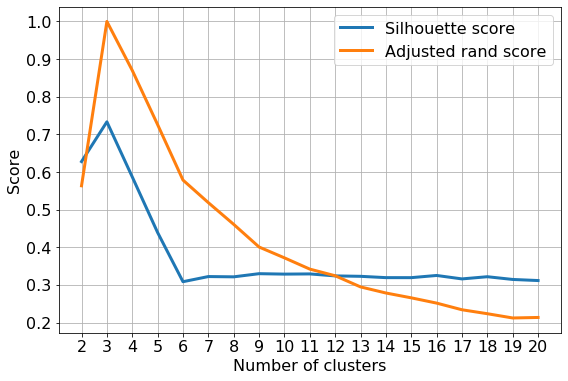

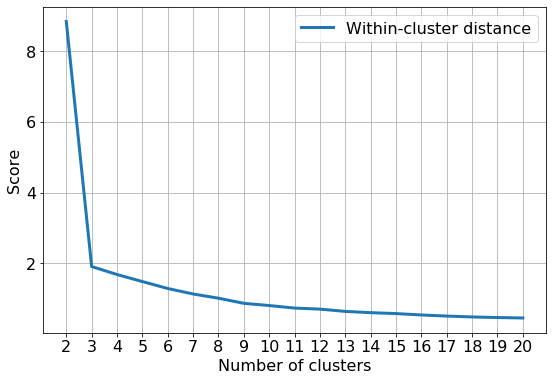

In [12]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters, silhouette_score_values, linewidth=3, label='Silhouette score')
plt.plot(n_clusters, adjusted_rand_score_values, linewidth=3, label='Adjusted rand score')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)
plt.grid(b=1)
plt.show()


plt.figure(figsize=(9, 6))
plt.plot(n_clusters, within_cluster_dist_values, linewidth=3, label='Within-cluster distance')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)
plt.grid(b=1)
plt.show()

## Other Clustering Algorithms

Short overview of other clustering algorithms you can find in `scikit-learn` library [here](https://scikit-learn.org/stable/modules/clustering.html):

<center><img src="img/clusters.png"></center>

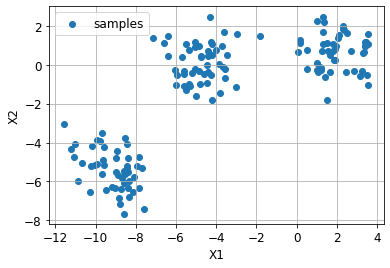

In [13]:
from sklearn import datasets

n_samples = 150
random_state = 170
X, y = datasets.make_blobs(centers=3, n_samples=n_samples, random_state=random_state, center_box=(-10, 10))

# To play with
# X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
# X, y = datasets.make_moons(n_samples=n_samples, noise=.05)
# X = np.random.rand(n_samples, 2)

plot_clusters(X, None)

In [14]:
# Import clustering algorithms
from sklearn import cluster

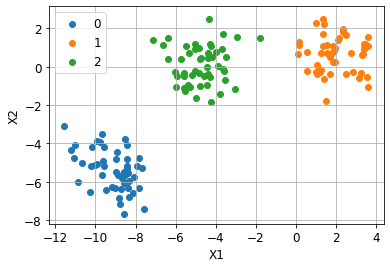

In [15]:
# MiniBatchKMeans

# Run clusterer
clusterer = cluster.MiniBatchKMeans(n_clusters=3, batch_size=100)
clusterer.fit(X)
y_pred = clusterer.predict(X)

# Plot clustering results
plot_clusters(X, y_pred)

**DBSCAN:**

<center><img src="img/dbscan.png" width="300"></center>

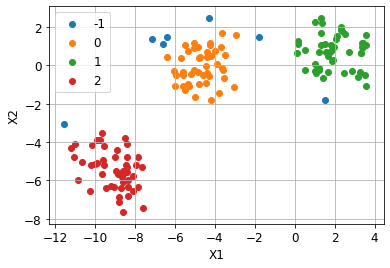

In [16]:
# DBSCAN

# Run clusterer
clusterer = cluster.DBSCAN(eps=1., min_samples=5)
y_pred = clusterer.fit_predict(X)

# Plot clustering results
plot_clusters(X, y_pred)

How to select parameters of DBSCAN algorithm properly? 

In [17]:
from sklearn.neighbors import NearestNeighbors

k = 5

# estimate k neighbors for each point in X
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)

# calculate distances for each of k nearest neighbors
dists, _ = nn.kneighbors(X, n_neighbors=k)

# take distaces only for the k-th neighbors
dist_kth = dists[:, k-1]

# sort the distances
dist_kth.sort()

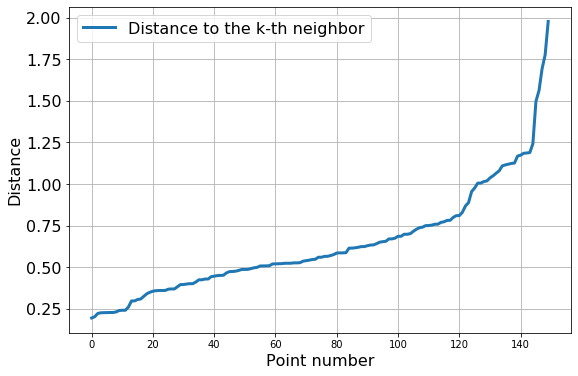

In [18]:
plt.figure(figsize=(9, 6))
plt.plot(dist_kth, linewidth=3, label='Distance to the k-th neighbor')
plt.xlabel('Point number', size=16)
plt.ylabel('Distance', size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)
plt.grid(b=1)
plt.show()

**Agglomerative Clustering:**

<center><img src="img/agglo.png" width="600"></center>

[image link](https://quantdare.com/hierarchical-clustering/)

In [19]:
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage

In [20]:
# calculate distance matrix between points
Z = linkage(X, method='average', metric='euclidean')

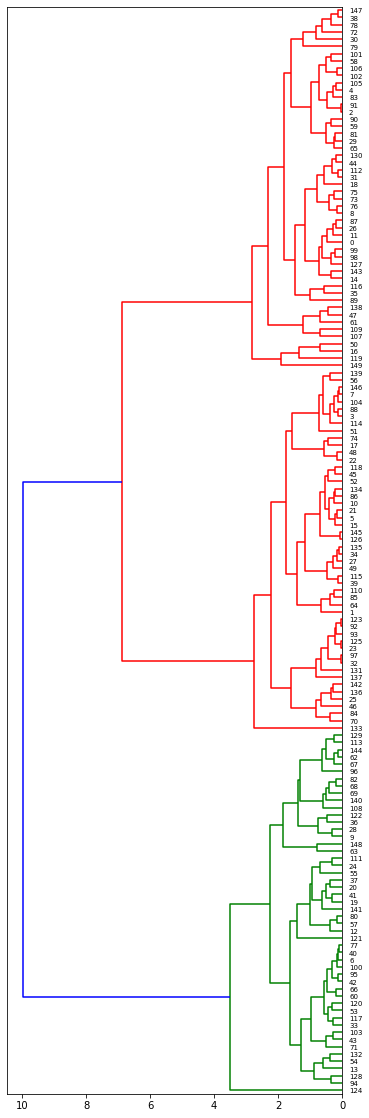

In [21]:
# plot dendrogram based on the distance matrix Z
plt.figure(figsize=(6, 20))
dend = dendrogram(Z, labels=np.arange(len(X)), orientation='left')
plt.yticks(size=7)
plt.show()

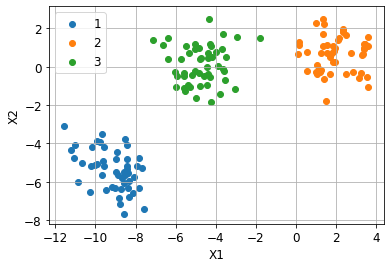

In [22]:
y_pred = fcluster(Z, 3, criterion='maxclust') # select 3 clusters using dendrogram

# Plot clustering results
plot_clusters(X, y_pred)

## Tasks:

- Rerun cells above for other datasets. Explain the clustering results.
- Try different number of clusters and other options. How can you explain what you see?

---

---

---

# Part 2: Scaling

## Data Preparation 

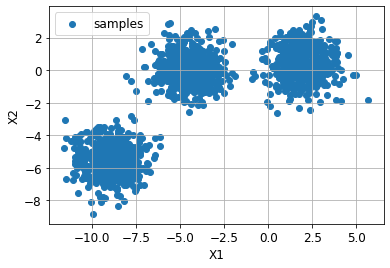

In [23]:
from sklearn import datasets

n_samples = 1500
random_state = 170
X, y = datasets.make_blobs(centers=3, n_samples=n_samples, random_state=random_state, center_box=(-10, 10))

# To play with
# X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
# X, y = datasets.make_moons(n_samples=n_samples, noise=.05)
# X = np.random.rand(n_samples, 2)

plot_clusters(X, None)

Multiply one of the sample features by a large number.

In [24]:
X_scaled = X.copy()
X_scaled[:, 1] *= 100

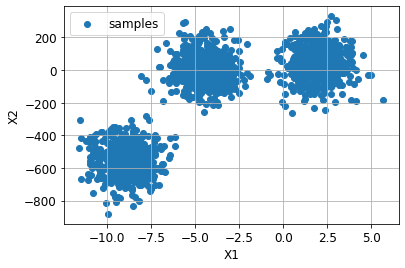

In [25]:
plot_clusters(X_scaled, None)

## Clustering without scaling

All clustering algorithms are based on distances between objects $\rho(x_{i}, x_{j})$. For an axample in 2D case:

$$
\rho(x_{i}, x_{j}) = \sqrt{ (x_{1i} - x_{1j})^{2} + (x_{2i} - x_{2j})^{2} }
$$

where $x_{1i}$ is the 1st input feature, $x_{2i}$ is the 2nd one.

Suppose, that the features have different scales:

$$
\frac{x_{2i}}{x_{1i}} = 1000
$$

Then

$$
\rho(x_{i}, x_{j}) = \sqrt{ (x_{1i} - x_{1j})^{2} + (x_{2i} - x_{2j})^{2} } \approx\sqrt{ (x_{2i} - x_{2j})^{2} }
$$

So, the 1st feature will not be taken into account by clustering algorithms.

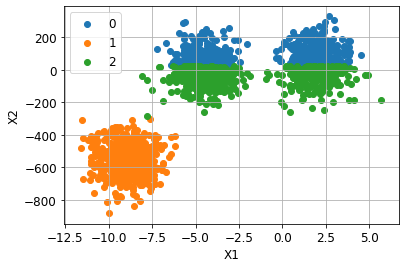

In [26]:
from sklearn import cluster

# Run clustering algorithm
clusterer = cluster.KMeans(n_clusters=3, n_init=10)
clusterer.fit(X_scaled)
y_pred = clusterer.predict(X_scaled)

# Show clustering results
plot_clusters(X_scaled, y_pred)

## Clustering with Standard Scaler

Standard Scaler transforms feature $x$ to a new feature $x_{new}$ with zero mean and unit variance by the following way:

$$
x_{new} = \frac{ x - \mu }{ \sigma }
$$

where

$$
\mu = \frac{1}{N} \sum_{i=1}^{N}x_{i}
$$

$$
\sigma = \sqrt{ \frac{1}{N-1} \sum_{i=1}^{N} (x_{i} - \mu)^{2} }
$$

This transforms all input features to the same scale.

In [27]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_scaled)
X_scaled_ss = ss.transform(X_scaled)

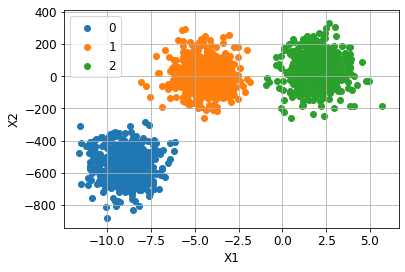

In [28]:
from sklearn import cluster

# Run clustering algorithm
clusterer = cluster.KMeans(n_clusters=3, n_init=10)
clusterer.fit(X_scaled_ss)
y_pred = clusterer.predict(X_scaled_ss)

# Show clustering results
plot_clusters(X_scaled, y_pred)

---

---

---

# Part 3: Real Data Example (Additional)

In [29]:
df_sns = pd.read_csv('data/snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


The sample has columns: 
* Year of creation
* Gender
* Age
* Number of friends
* 36 keywords that are found in the facebook profile (interests, community, meetings)

## Create Matrix X

In [30]:
df_sns.columns

Index(['gradyear', 'gender', 'age', 'friends', 'basketball', 'football',
       'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading',
       'baseball', 'tennis', 'sports', 'cute', 'sex', 'sexy', 'hot', 'kissed',
       'dance', 'band', 'marching', 'music', 'rock', 'god', 'church', 'jesus',
       'bible', 'hair', 'dress', 'blonde', 'mall', 'shopping', 'clothes',
       'hollister', 'abercrombie', 'die', 'death', 'drunk', 'drugs'],
      dtype='object')

In [31]:
word_cols = ['basketball', 'football',
             'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading',
             'baseball', 'tennis', 'sports', 'cute', 'sex', 'sexy', 'hot', 'kissed',
             'dance', 'band', 'marching', 'music', 'rock', 'god', 'church', 'jesus',
             'bible', 'hair', 'dress', 'blonde', 'mall', 'shopping', 'clothes',
             'hollister', 'abercrombie', 'die', 'death', 'drunk', 'drugs']

X = df_sns[word_cols].values

## Clustering

In [32]:
clusterer = MyKmeans(n_clusters=9, max_iter=10, n_init=10)
clusterer.fit(X)
y_pred = clusterer.predict(X)

In [33]:
metrics.silhouette_score(X, y_pred)

0.19488791774143843

In [34]:
clusterer.best_cluster_centers

array([[0.2887538 , 0.22796353, 0.12158055, 0.14285714, 0.13981763,
        0.13677812, 0.09726444, 0.07902736, 0.09422492, 0.19452888,
        0.31306991, 0.18844985, 0.16717325, 0.18541033, 0.09118541,
        0.36474164, 0.34042553, 0.02735562, 1.        , 0.27051672,
        8.55927052, 0.9787234 , 1.67477204, 0.36778116, 0.51367781,
        0.15805471, 0.12462006, 0.25531915, 0.35258359, 0.20972644,
        0.03647416, 0.03647416, 0.50455927, 0.37082067, 0.17933131,
        0.07598784],
       [0.84766585, 0.81326781, 0.39066339, 0.37837838, 0.25798526,
        0.33169533, 0.32678133, 0.41523342, 0.17936118, 0.71744472,
        1.01474201, 5.01474201, 0.53316953, 0.38329238, 1.87223587,
        1.20884521, 1.07616708, 0.07616708, 3.59459459, 1.85257985,
        1.19410319, 0.41523342, 0.14004914, 0.04668305, 4.91400491,
        0.44226044, 1.77395577, 0.83046683, 0.78869779, 0.96314496,
        0.2972973 , 0.28009828, 1.18427518, 0.55036855, 0.72727273,
        0.81818182],
      